# Download Data Set

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("digvijayyadav/frenchenglish")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/frenchenglish


# Loading Libraries

In [8]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.2 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading Data Set

In [10]:
file_path =os.path.join(path, 'fra.txt')

In [11]:
data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            english = parts[0]
            french = parts[1]
            attribution = parts[2] if len(parts) > 2 else ""
            data.append([english, french, attribution])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["English", "French", "Attribution"])

In [20]:
df.head()

,English,French,Attribution
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Cours !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,Courez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [21]:
df.shape

(177210, 3)

In [12]:
df.drop(columns=['Attribution'], inplace =True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177210 entries, 0 to 177209
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  177210 non-null  object
 1   French   177210 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [25]:
df.isnull().sum()

,0
English,0
French,0


In [26]:
df.duplicated().sum()

np.int64(0)

# Spliting And Appending

In [6]:
input_texts = df['English']
target_texts = ['\t' + pair + '\n' for pair in df['French']]

# Tokenization

In [13]:
input_tokenizer = Tokenizer(char_level=True)
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

In [14]:
target_tokenizer = Tokenizer(char_level = True)
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)

# Padding

In [15]:
max_encoder_len = max(len(seq) for seq in input_sequences)

In [16]:
max_decoder_len = max(len(seq) for seq in target_sequences)

In [17]:
max_encoder_len, max_decoder_len

(262, 327)

In [18]:
encoder_input = pad_sequences(input_sequences, maxlen = max_encoder_len ,truncating ='post' )

In [19]:
decoder_input = pad_sequences(target_sequences, maxlen = max_encoder_len ,truncating ='post' )

# Convert to one-hot (for character-level)

In [20]:
num_encoder_tokens = len(input_tokenizer.word_index) +1
num_decoder_tokens = len(target_tokenizer.word_index) +1

In [21]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_len, num_encoder_tokens),
    dtype = 'float32'
)

In [22]:
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_len, num_decoder_tokens),
    dtype = 'float32'
)

In [23]:
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_len, num_decoder_tokens),
    dtype='float32'
)

# Fill one-hot arrays

In [24]:
for i, (input_seq, target_seq) in enumerate(zip(input_sequences, target_sequences)):
    for t, token in enumerate(input_seq):
        encoder_input_data[i, t, token] = 1.
    for t, token in enumerate(target_seq):
        decoder_input_data[i, t, token] = 1.
        if t > 0:
            decoder_target_data[i, t-1, token] = 1.

# Building the Encoder-Decoder Model

## Encoder

In [25]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

## Decoder

In [26]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _ , _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Final Model

In [27]:
model =Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [28]:
model.compile(
    optimizer = 'adam',
    metrics = ['accuracy'],
    loss = 'categorical_crossentropy'
)

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 65)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 84)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    329,728 │ input_layer[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    349,184 │ input_layer_1[0]… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 84)  │     21,588 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 700,500 (2.67 MB)

 Trainable params: 700,500 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.utils import plot_model

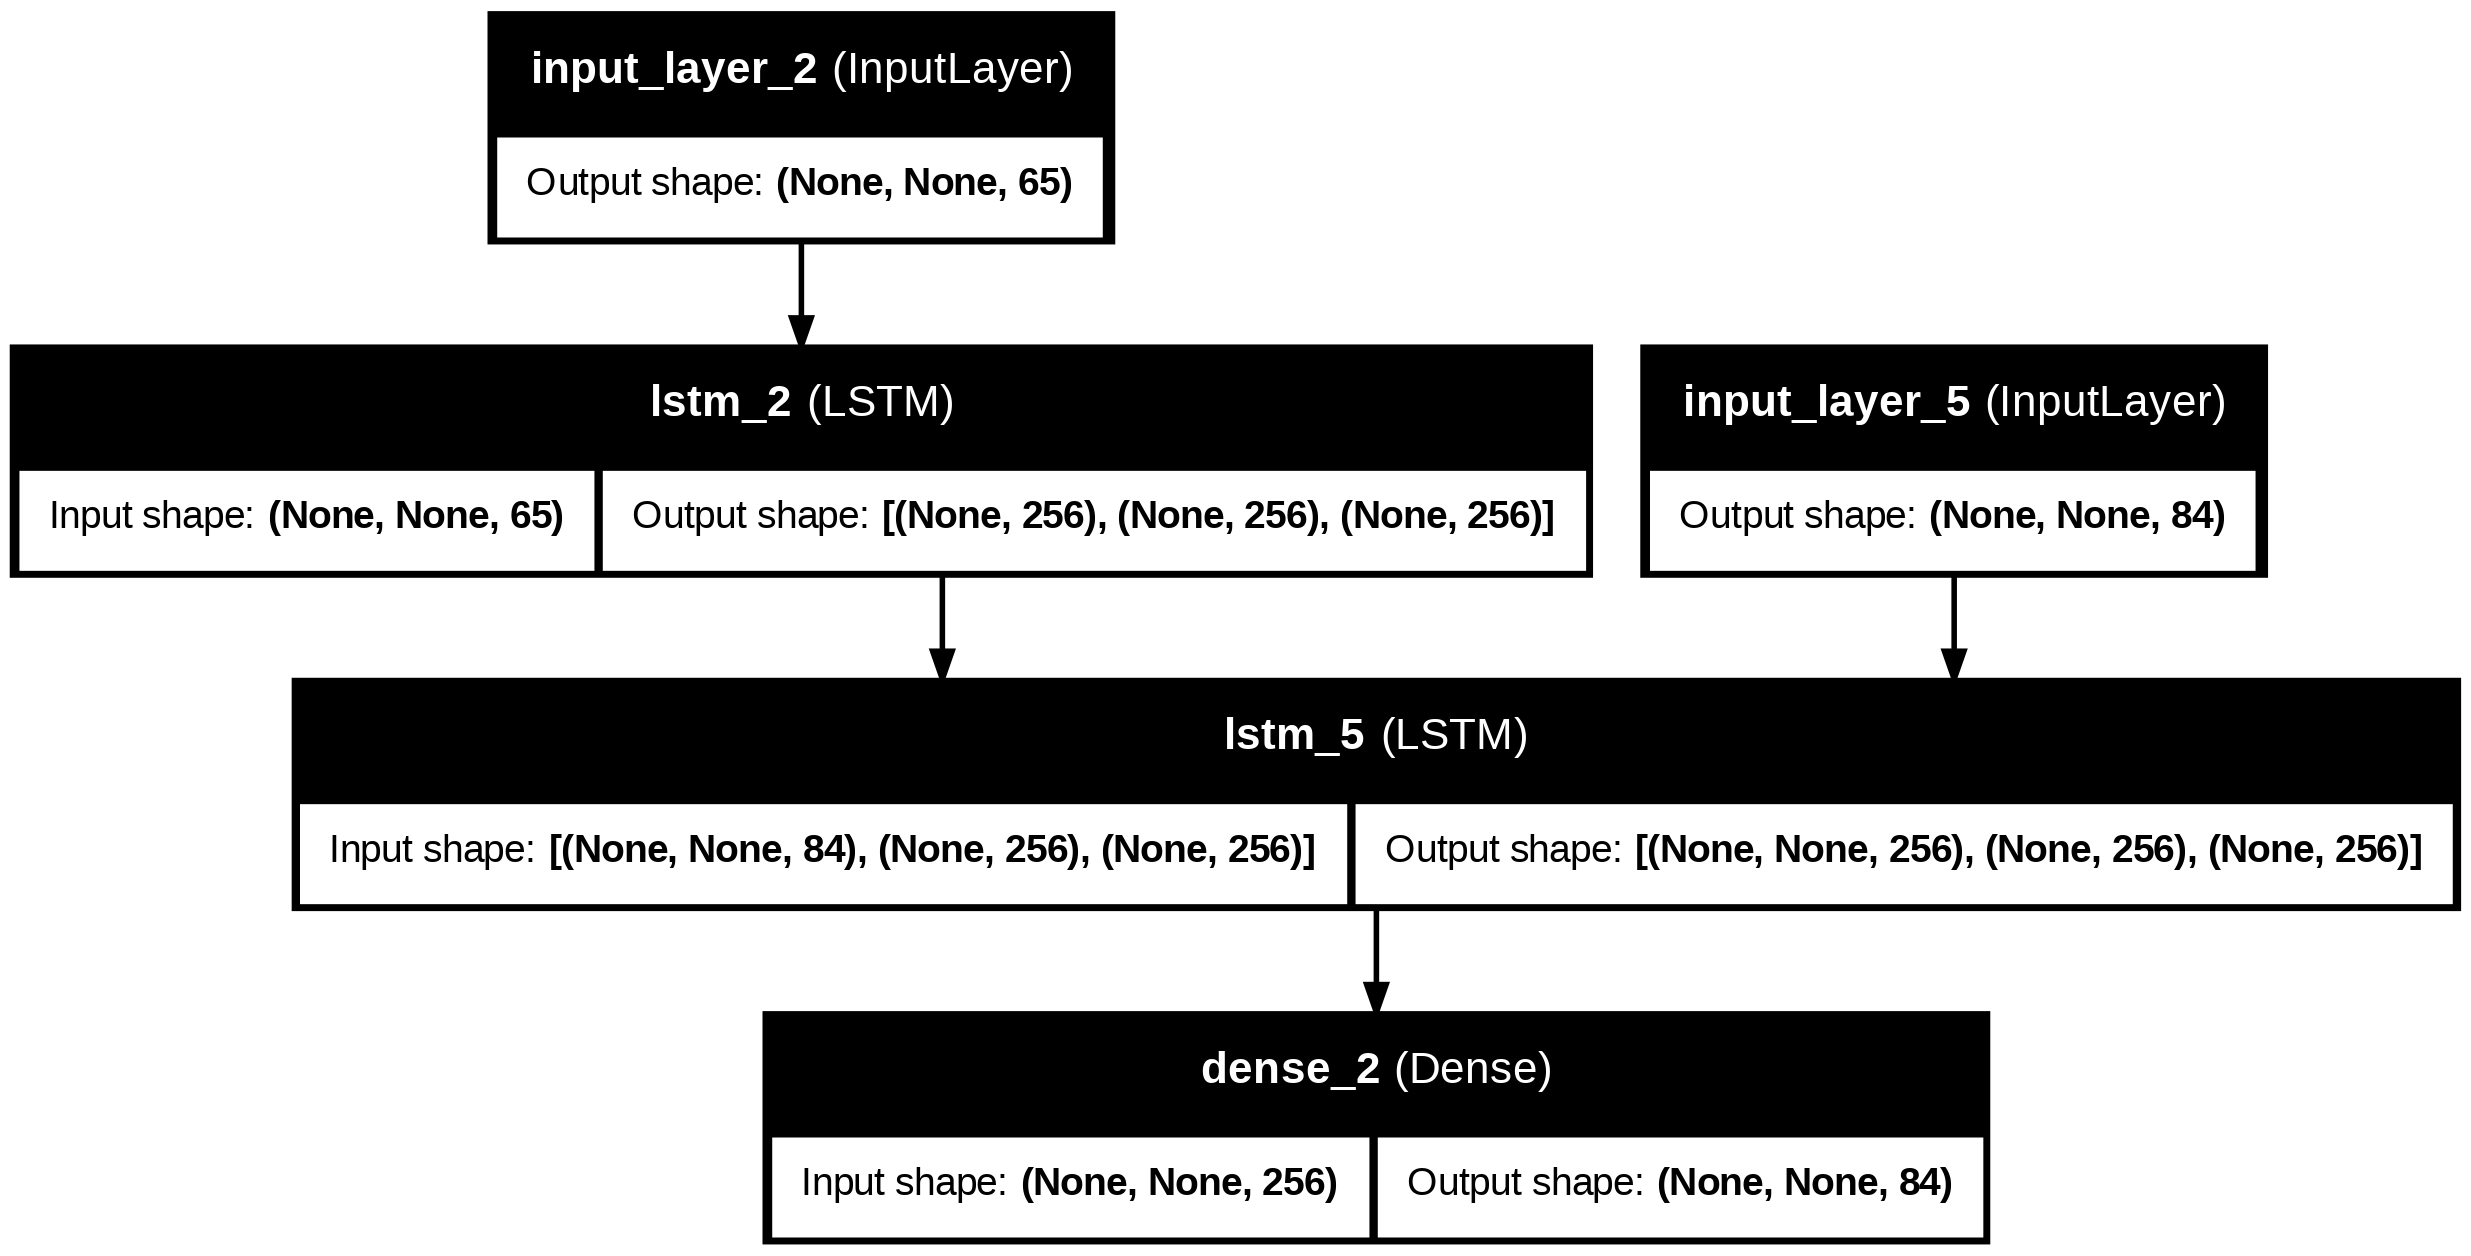

In [51]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Training Model

In [32]:
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=100,
    validation_split=0.2
)

# Inference models (for prediction)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# Prediction function

In [ ]:
def translate(input_text):
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_encoder_len, padding='post')
    input_seq = tf.one_hot(input_seq, depth=num_encoder_tokens)
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_tokenizer.word_index['\t']] = 1.

    decoded_sentence = ''
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_tokenizer.index_word[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
            len(decoded_sentence) > max_decoder_len):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence
